# Lab: Sentiment classification 2
First, we import some of libraries.

In [1]:
import csv
import pandas as pd
import sklearn.model_selection as skm
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

## Loading data

We use a subset of the *Yelp reviews* dataset: each short text is accompanied with a sentiment label (0 -- negative, 1 -- positive). 

In [3]:
data = pd.read_csv('yelp_labelled.txt', header=None, sep='\t')
data.head(5)

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Data preparation
We split the data into train and test subsets and transform texts into vectors.

In [6]:
X_text = data[0]
y = data[1]
X_text_train, X_text_test, y_train, y_test = skm.train_test_split(X_text, y, test_size=0.2, stratify=y, random_state=0)

## Data encoding 
We import the `fasttext` library. We also need to load the model. 

*In my experience, it's faster to manually download/unzip the model and provide a path to the local file.*

In [8]:
import fasttext
model = fasttext.load_model("cc.en.300.bin")

Now we convert review texts into vectors, which are averge of normalized vectors of individual words in the sentence, see https://github.com/facebookresearch/fastText/issues/323 .

In [9]:
X_train = [model.get_sentence_vector(text) for text in X_text_train]
X_test = [model.get_sentence_vector(text) for text in X_text_test]

## Training and testing

We fit an SVM and test it. 

In [10]:
clf = SVC()
clf.fit(X_train, y_train)
print('Test set accuracy: %.3f' % accuracy_score(y_test, clf.predict(X_test)))

Test set accuracy: 0.785


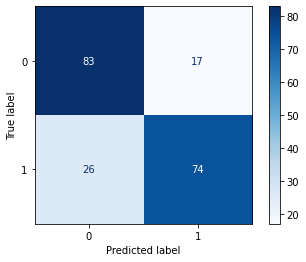

In [11]:
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
    )

## A ready-to-use sentiment classifier

We use a trained sentiment classifier from Stanza package, see https://stanfordnlp.github.io/stanza/sentiment.html

First, we import Stanza...

In [13]:
import stanza

...and define our pipline -- we only need the tokenizer and sentiment analysis. To prevent Stanza from downloading the model every time you use it, add `download_method=None`, see https://stanfordnlp.github.io/stanza/download_models.html

Some yelp revews contain more than one sentence, so we use `tokenize_no_ssplit=True` to prevent Stanza from splitting them, see https://stanfordnlp.github.io/stanza/tokenize.html

In [15]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment', tokenize_no_ssplit=True)

2023-11-09 12:53:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-11-09 12:53:17 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2023-11-09 12:53:17 INFO: Using device: cpu
2023-11-09 12:53:17 INFO: Loading: tokenize
2023-11-09 12:53:17 INFO: Loading: sentiment
2023-11-09 12:53:17 INFO: Done loading processors!


We concatenate the collection into one document, using double new lines as forced sentence boundaries, and process the document. 

In [16]:
collection = '\n\n'.join(X_text_test)
doc = nlp(collection)

Now we retrieve sentiment labels assigned by the model. Note that the model performs three-class classification (0 -- negative, 1 -- neutral, 2 -- positive); we merge negative and neutral labels.

In [17]:
stanza_predictions = []
for i, sentence in enumerate(doc.sentences):
    if sentence.sentiment == 0 or sentence.sentiment == 1:
        stanza_predictions.append(0)
    if sentence.sentiment == 2:
        stanza_predictions.append(1)

In [18]:
print('Test set accuracy: %.3f' % accuracy_score(y_test, stanza_predictions))

Test set accuracy: 0.920


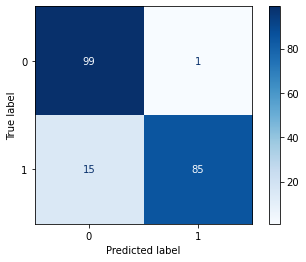

In [64]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        stanza_predictions,
        cmap=plt.cm.Blues,
    )